# Week6 — Predicting Product Prices (Merged for Colab, multi-cell)
This notebook merges selected Week6 notebooks into separate code cells for Colab.
- Included: day1.ipynb, lite.ipynb (as day2), day3.ipynb, day4-results.ipynb (as day4), day5-results.ipynb (as day5)
- Upload `items.py`, `loaders.py`, `testing.py`, `train_lite.pkl`, `test_lite.pkl`, `human_input.csv`, `human_output.csv` to Colab before running.


In [ ]:
# Install required libraries (edit if needed)
!pip install -q pandas scikit-learn matplotlib seaborn xgboost transformers torch tqdm


In [ ]:
import sys, os

# Make sure /content is in the module search path
if '/content' not in sys.path:
    sys.path.insert(0, '/content')

# Optional: print current working dir and verify file presence
print("Current working directory:", os.getcwd())
print("Checking files in /content:")
print(os.listdir('/content'))



Current working directory: /content
Checking files in /content:
['.config', 'items.py', 'human_input.csv', 'testing.py', 'loaders.py', 'human_output.csv', '__pycache__', 'sample_data']


In [ ]:
# Deduplicated imports collected from all notebooks
import os
from dotenv import load_dotenv
from huggingface_hub import login
from datasets import load_dataset, Dataset, DatasetDict
import matplotlib.pyplot as plt
from huggingface_hub import HfApi
from items.py import Item
import random
from collections import Counter, defaultdict
import numpy as np
import pickle
from loaders import ItemLoader
import math
import json
from collections import Counter
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
import re
from openai import OpenAI
from anthropic import Anthropic
from testing import Tester
import csv


In [ ]:
# Install gensim
#!pip install -q gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 88.0 MB/s eta 0:00:00


In [ ]:
#hf_token = os.environ['HF_TOKEN_PROJ']
#login(hf_token, add_to_git_credential=True)




In [ ]:

load_dotenv(override=True)
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
os.environ['ANTHROPIC_API_KEY'] = os.getenv('ANTHROPIC_API_KEY', 'your-key-if-not-using-env')
os.environ['HF_TOKEN_PROJ'] = os.getenv('HF_TOKEN_PROJ', 'your-key-if-not-using-env')


In [ ]:
from huggingface_hub import login
login()


In [ ]:


token = os.environ.get("HF_TOKEN1", "").strip()
api = HfApi()
try:
    user_info = api.whoami(token=token)
    print("Logged in as:", user_info.get("name"))  # “name” is your HF username
except Exception as e:
    print("Login check failed:", type(e), e)


Logged in as: himpat202


In [ ]:

%matplotlib inline


In [ ]:
!pip install datasets==3.6.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 13.6 MB/s eta 0:00:00
  Attempting uninstall: datasets
    Found existing installation: datasets 4.0.0
    Uninstalling datasets-4.0.0:
      Successfully uninstalled datasets-4.0.0


In [ ]:
# restart runtime after this cell (Colab: Runtime -> Restart runtime)
!pip install "datasets<4.0.0" "huggingface-hub<1.0.0"


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 35.5 MB/s eta 0:00:00
  Attempting uninstall: datasets
    Found existing installation: datasets 4.0.0
    Uninstalling datasets-4.0.0:
      Successfully uninstalled datasets-4.0.0


In [ ]:
dataset = load_dataset("McAuley-Lab/Amazon-Reviews-2023", f"raw_meta_Appliances", split="full", trust_remote_code=True)

raw/meta_categories/meta_Appliances.json(…):   0%|          | 0.00/285M [00:00<?, ?B/s]

Generating full split: 0 examples [00:00, ? examples/s]

In [ ]:

dataset


Dataset({
    features: ['main_category', 'title', 'average_rating', 'rating_number', 'features', 'description', 'price', 'images', 'videos', 'store', 'categories', 'details', 'parent_asin', 'bought_together', 'subtitle', 'author'],
    num_rows: 94327
})

In [ ]:

print(f"total number of appliances are : {len(dataset):,}")


total number of appliances are : 94,327


In [ ]:

datapoint = dataset[2]

print(datapoint)


{'main_category': 'Tools & Home Improvement', 'title': 'Clothes Dryer Drum Slide, General Electric, Hotpoint, WE1M333, WE1M504', 'average_rating': 3.5, 'rating_number': 18, 'features': [], 'description': ['Brand new dryer drum slide, replaces General Electric, Hotpoint, RCA, WE1M333, WE1M504.'], 'price': 'None', 'images': {'hi_res': ['https://m.media-amazon.com/images/I/51TIpnkrEpL._AC_SL1500_.jpg'], 'large': ['https://m.media-amazon.com/images/I/21HQKcHPIkL._AC_.jpg'], 'thumb': ['https://m.media-amazon.com/images/I/21HQKcHPIkL._AC_US75_.jpg'], 'variant': ['MAIN']}, 'videos': {'title': [], 'url': [], 'user_id': []}, 'store': 'GE', 'categories': ['Appliances', 'Parts & Accessories'], 'details': '{"Manufacturer": "RPI", "Part Number": "WE1M333,", "Item Weight": "0.352 ounces", "Package Dimensions": "5.5 x 4.7 x 0.4 inches", "Item model number": "WE1M333,", "Is Discontinued By Manufacturer": "No", "Item Package Quantity": "1", "Batteries Included?": "No", "Batteries Required?": "No", "Bes

In [ ]:


print(datapoint["title"])
print(datapoint["description"])
print(datapoint["features"])
print(datapoint["details"])
print(datapoint["price"])


Clothes Dryer Drum Slide, General Electric, Hotpoint, WE1M333, WE1M504
['Brand new dryer drum slide, replaces General Electric, Hotpoint, RCA, WE1M333, WE1M504.']
[]
{"Manufacturer": "RPI", "Part Number": "WE1M333,", "Item Weight": "0.352 ounces", "Package Dimensions": "5.5 x 4.7 x 0.4 inches", "Item model number": "WE1M333,", "Is Discontinued By Manufacturer": "No", "Item Package Quantity": "1", "Batteries Included?": "No", "Batteries Required?": "No", "Best Sellers Rank": {"Tools & Home Improvement": 1315213, "Parts & Accessories": 181194}, "Date First Available": "February 25, 2014"}
None


In [ ]:


prices = 0
for datapoint in dataset:
    try:
        price = float(datapoint["price"])
        if price > 0:
            prices += 1
    except ValueError as e:
        pass

print(f"There are {prices:,} with prices which is {prices/len(dataset)*100:,.1f}%")


There are 46,726 with prices which is 49.5%


In [ ]:


prices = []
lengths = []
for datapoint in dataset:
    try:
        price = float(datapoint["price"])
        if price > 0:
            prices.append(price)
            contents = datapoint["title"] + str(datapoint["description"]) + str(datapoint["features"]) + str(datapoint["details"])
            lengths.append(len(contents))
    except ValueError as e:
        pass


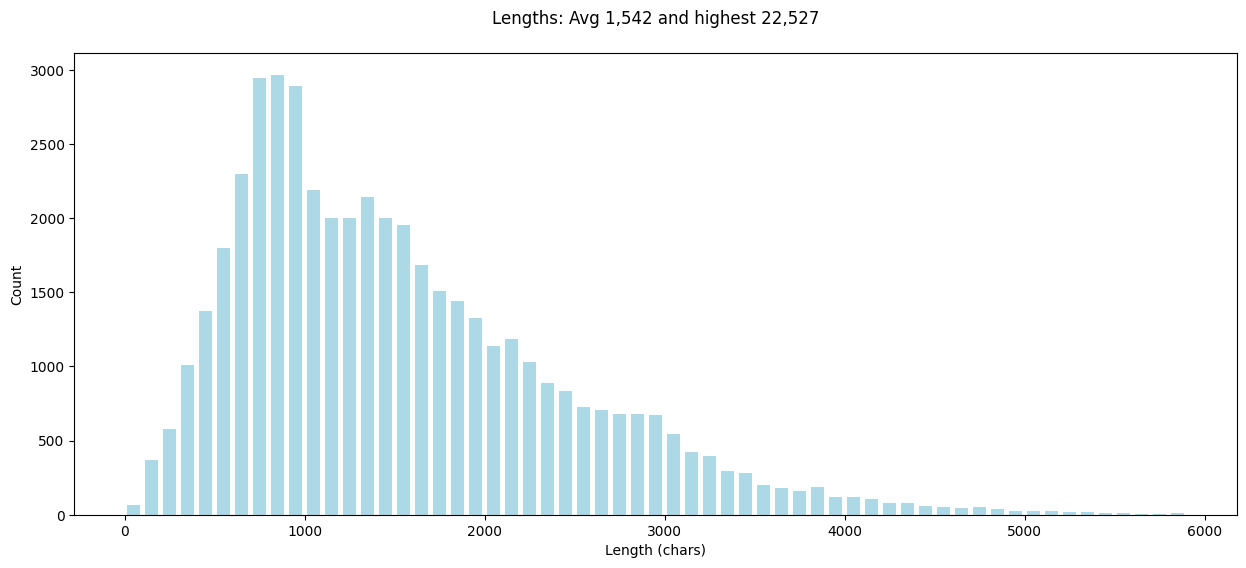

In [ ]:


plt.figure(figsize=(15, 6))
plt.title(f"Lengths: Avg {sum(lengths)/len(lengths):,.0f} and highest {max(lengths):,}\n")
plt.xlabel('Length (chars)')
plt.ylabel('Count')
plt.hist(lengths, rwidth=0.7, color="lightblue", bins=range(0, 6000, 100))
plt.show()


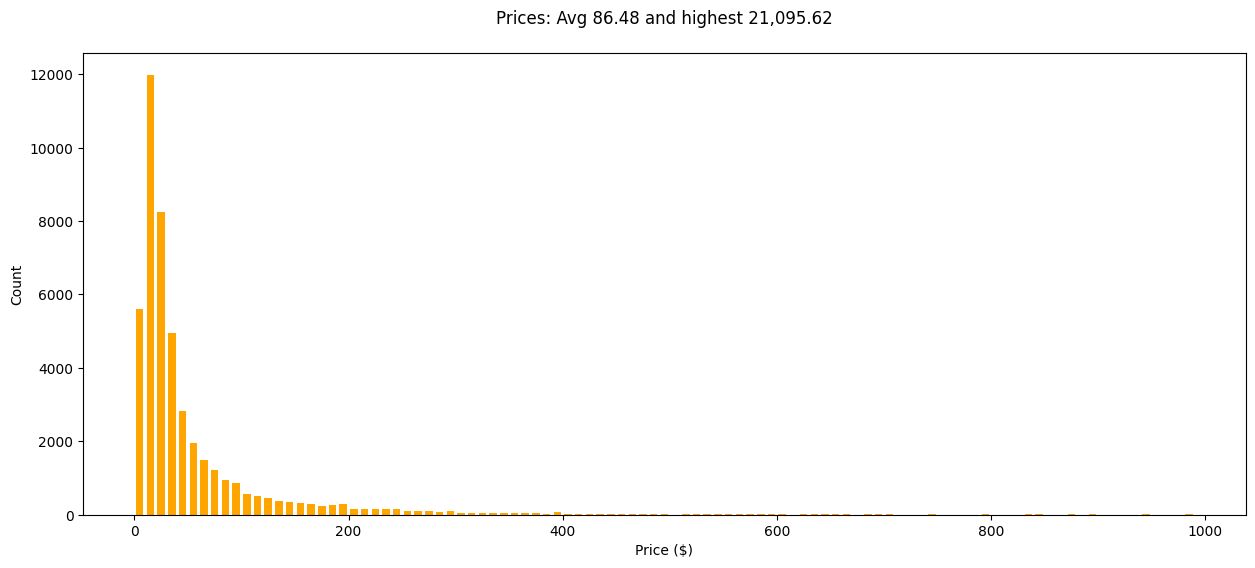

In [ ]:


plt.figure(figsize=(15, 6))
plt.title(f"Prices: Avg {sum(prices)/len(prices):,.2f} and highest {max(prices):,}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="orange", bins=range(0, 1000, 10))
plt.show()


In [ ]:


for datapoint in dataset:
    try:
        price = float(datapoint["price"])
        if price > 21000:
            print(datapoint['title'])
    except ValueError as e:
        pass


TurboChef BULLET Rapid Cook Electric Microwave Convection Oven


In [ ]:


items = []
for datapoint in dataset:
    try:
        price = float(datapoint["price"])
        if price > 0:
            item = Item(datapoint, price)
            if item.include:
                items.append(item)
    except ValueError as e:
        pass

print(f"There are {len(items):,} items")


There are 29,191 items


In [ ]:


items[1]


<WP67003405 67003405 Door Pivot Block - Compatible Kenmore KitchenAid Maytag Whirlpool Refrigerator - Replaces AP6010352 8208254 PS11743531 - Quick DIY Repair Solution = $16.52>

In [ ]:

items[0]


<WD12X10327 Rack Roller and stud assembly Kit (4 Pack) by AMI PARTS Replaces AP4980629 PS3486910 1811003 = $8.99>

In [ ]:

print(items[1].prompt)


How much does this cost to the nearest dollar?

Door Pivot Block - Compatible Kenmore KitchenAid Maytag Whirlpool Refrigerator - Replaces - Quick DIY Repair Solution
Pivot Block For Vernicle Mullion Strip On Door - A high-quality exact equivalent for part numbers and Compatibility with major brands - Door Guide is compatible with Whirlpool, Amana, Dacor, Gaggenau, Hardwick, Jenn-Air, Kenmore, KitchenAid, and Maytag. Quick DIY repair - Refrigerator Door Guide Pivot Block Replacement will help if your appliance door doesn't open or close. Wear work gloves to protect your hands during the repair process. Attentive support - If you are uncertain about whether the block fits your refrigerator, we will help. We generally put forth a valiant effort to guarantee you are totally

Price is $17.00


In [ ]:


print(items[100].prompt)


How much does this cost to the nearest dollar?

Samsung Assembly Ice Maker-Mech
This is an O.E.M. Authorized part, fits with various Samsung brand models, oem part # this product in manufactured in south Korea. This is an O.E.M. Authorized part Fits with various Samsung brand models Oem part # This is a Samsung replacement part Part Number This is an O.E.M. part Manufacturer J&J International Inc., Part Weight 1 pounds, Dimensions 18 x 12 x 6 inches, model number Is Discontinued No, Color White, Material Acrylonitrile Butadiene Styrene, Quantity 1, Certification Certified frustration-free, Included Components Refrigerator-replacement-parts, Rank Tools & Home Improvement Parts & Accessories 31211, Available April 21, 2011

Price is $118.00


In [ ]:


print(items[100].test_prompt())


How much does this cost to the nearest dollar?

Samsung Assembly Ice Maker-Mech
This is an O.E.M. Authorized part, fits with various Samsung brand models, oem part # this product in manufactured in south Korea. This is an O.E.M. Authorized part Fits with various Samsung brand models Oem part # This is a Samsung replacement part Part Number This is an O.E.M. part Manufacturer J&J International Inc., Part Weight 1 pounds, Dimensions 18 x 12 x 6 inches, model number Is Discontinued No, Color White, Material Acrylonitrile Butadiene Styrene, Quantity 1, Certification Certified frustration-free, Included Components Refrigerator-replacement-parts, Rank Tools & Home Improvement Parts & Accessories 31211, Available April 21, 2011

Price is $


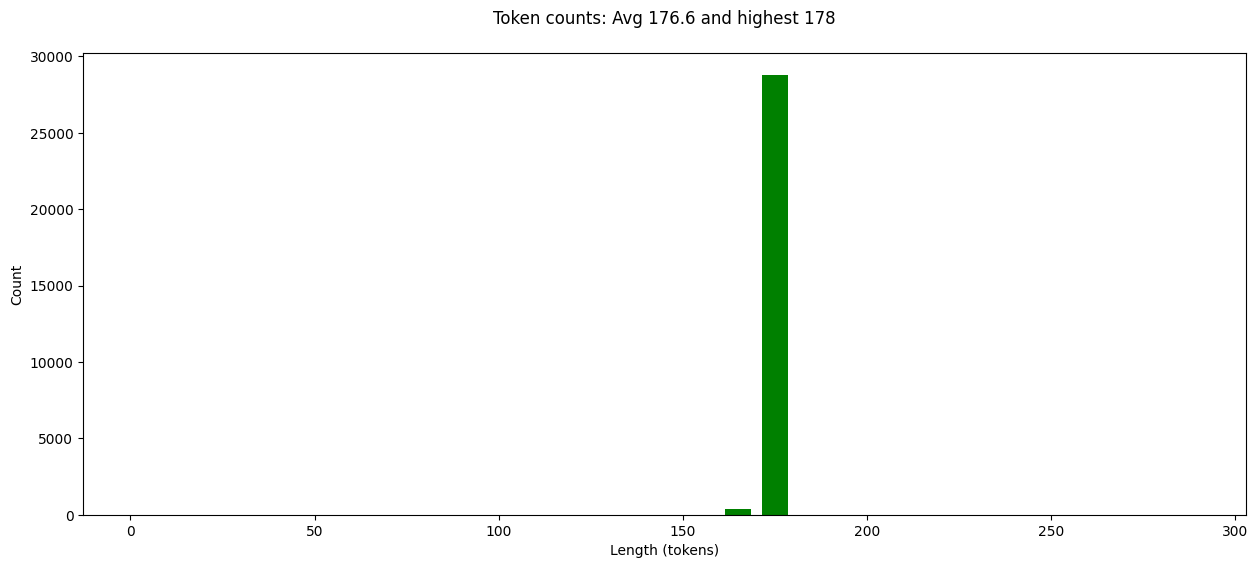

In [ ]:

tokens = [item.token_count for item in items]
plt.figure(figsize=(15, 6))
plt.title(f"Token counts: Avg {sum(tokens)/len(tokens):,.1f} and highest {max(tokens):,}\n")
plt.xlabel('Length (tokens)')
plt.ylabel('Count')
plt.hist(tokens, rwidth=0.7, color="green", bins=range(0, 300, 10))
plt.show()


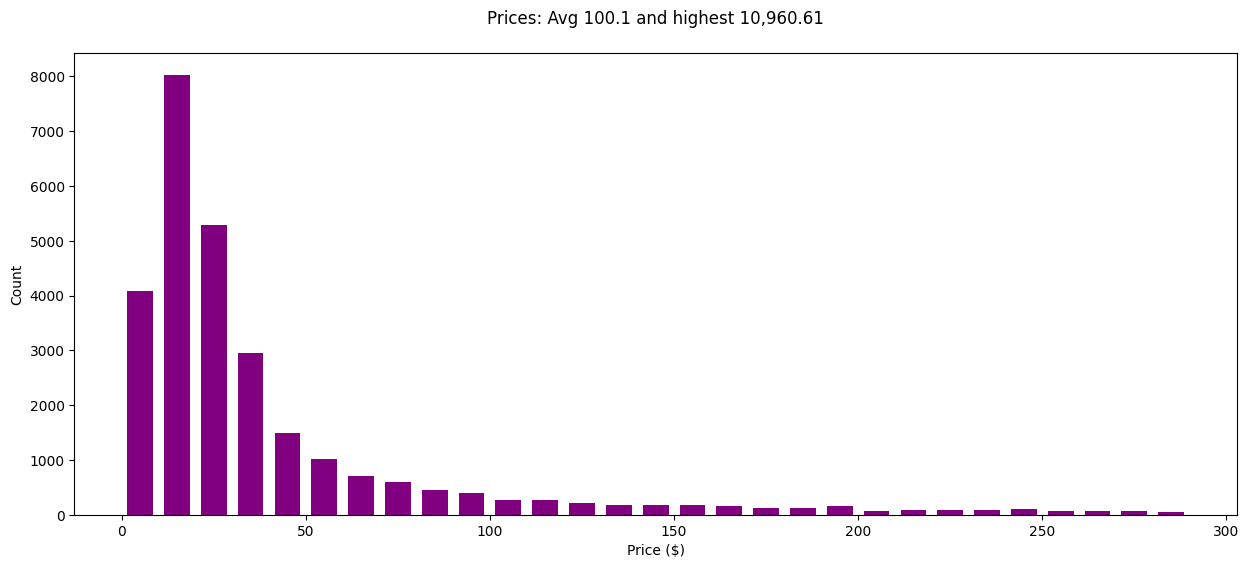

In [ ]:


prices = [item.price for item in items]
plt.figure(figsize=(15, 6))
plt.title(f"Prices: Avg {sum(prices)/len(prices):,.1f} and highest {max(prices):,}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="purple", bins=range(0, 300, 10))
plt.show()


In [ ]:

dataset_names = [
    "Appliances",
]


In [ ]:

items = []
for dataset_name in dataset_names:
    loader = ItemLoader(dataset_name)
    items.extend(loader.load())


Loading dataset Appliances


100%|██████████| 95/95 [01:06<00:00,  1.43it/s]


Completed Appliances with 28,625 datapoints in 1.2 mins


In [ ]:

print(f"A grand total of {len(items):,} items")


A grand total of 28,625 items


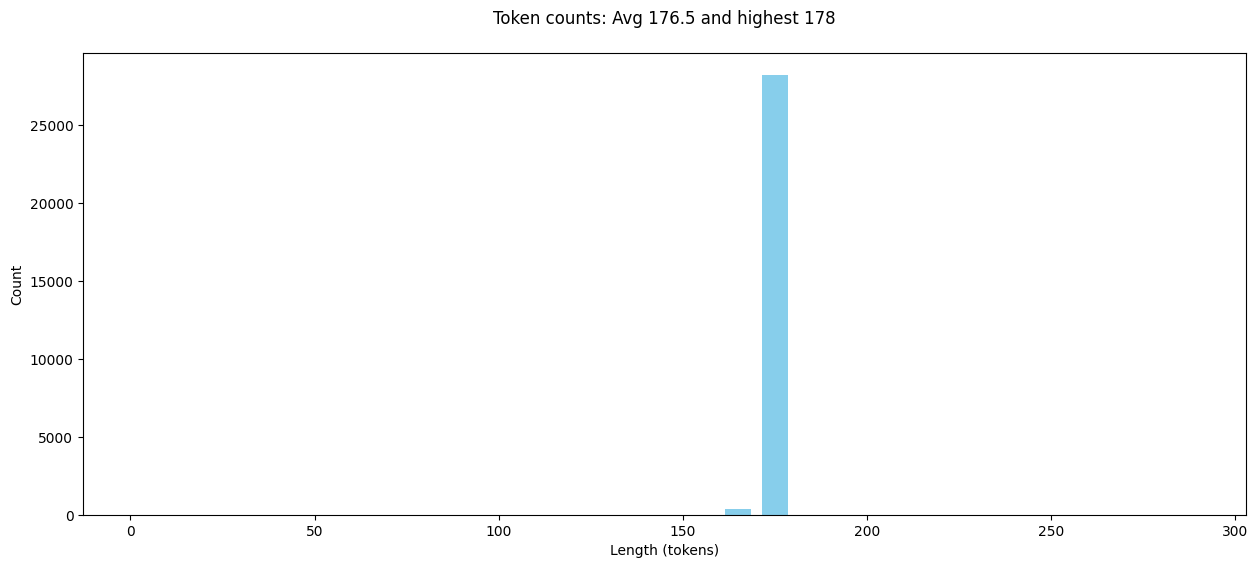

In [ ]:

tokens = [item.token_count for item in items]
plt.figure(figsize=(15, 6))
plt.title(f"Token counts: Avg {sum(tokens)/len(tokens):,.1f} and highest {max(tokens):,}\n")
plt.xlabel('Length (tokens)')
plt.ylabel('Count')
plt.hist(tokens, rwidth=0.7, color="skyblue", bins=range(0, 300, 10))
plt.show()


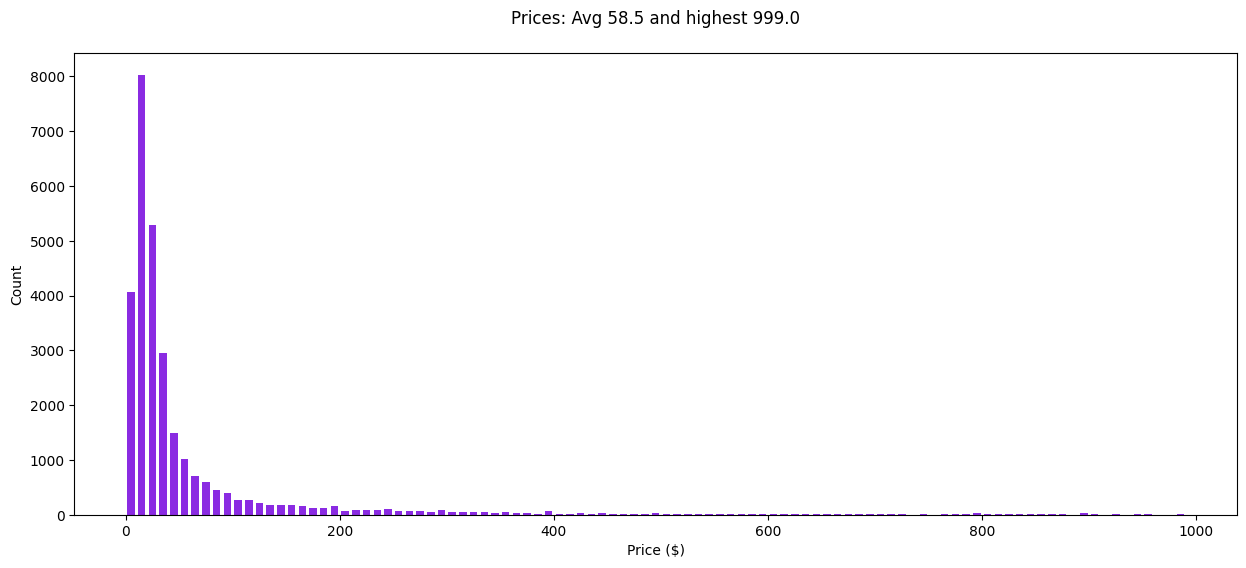

In [ ]:


prices = [item.price for item in items]
plt.figure(figsize=(15, 6))
plt.title(f"Prices: Avg {sum(prices)/len(prices):,.1f} and highest {max(prices):,}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="blueviolet", bins=range(0, 1000, 10))
plt.show()


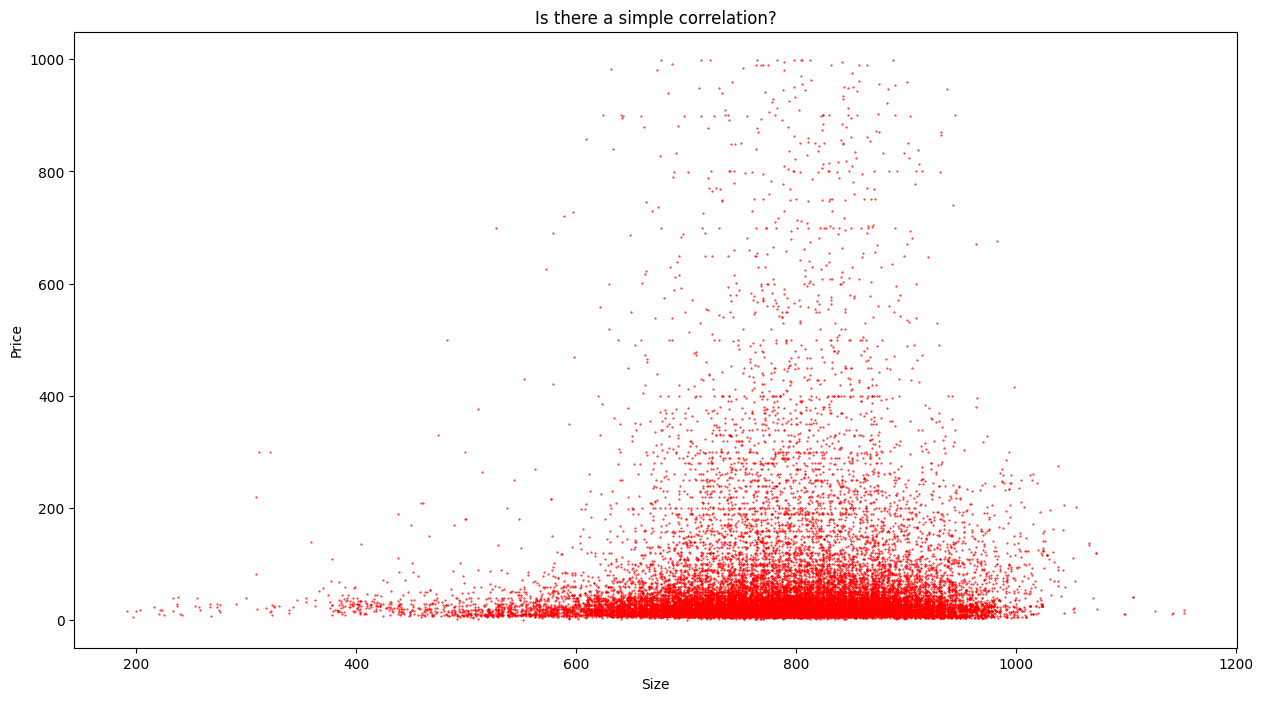

In [ ]:


sample = items

sizes = [len(item.prompt) for item in sample]
prices = [item.price for item in sample]

plt.figure(figsize=(15, 8))
plt.scatter(sizes, prices, s=0.2, color="red")

plt.xlabel('Size')
plt.ylabel('Price')
plt.title('Is there a simple correlation?')

plt.show()


In [ ]:

def report(item):
    prompt = item.prompt
    tokens = Item.tokenizer.encode(item.prompt)
    print(prompt)
    print(tokens[-10:])
    print(Item.tokenizer.batch_decode(tokens[-10:]))


In [ ]:

report(sample[50])


How much does this cost to the nearest dollar?

285746 OR 285811 Washer Agitator Support And Dogs Compatible with Inglis, Whirlpool, Kenmore, Roper, Admiral
285746 OR 285811 Agitator support and dogs Washing machine agitator repair kit with a medium length cam Agitator support and dogs for two piece agitators.This kit should be used when the top part of the agitator is not moving properly but the bottom part is. Replaces Old Numbers 2744 285746 285811 Washer Agitator Repair Kit. This part works with the following brands Whirlpool, Roper, Admiral, Maytag, Hardwick, Jenn-Air, Estate, Magic Chef, Crosley, Inglis, Norge, Modern Maid, Amana, Kenmore

Price is $8.00
[11, 14594, 6518, 271, 7117, 374, 400, 23, 13, 410]
[',', ' Ken', 'more', '\n\n', 'Price', ' is', ' $', '8', '.', '00']


In [ ]:

random.seed(42)
random.shuffle(sample)
train = sample[:25_000]
test = sample[25_000:27_000]
print(f"Divided into a training set of {len(train):,} items and test set of {len(test):,} items")


Divided into a training set of 25,000 items and test set of 2,000 items


In [ ]:

print(train[0].prompt)


How much does this cost to the nearest dollar?

and Replacement Range Cooktop Drip Pans fit GE, Hotpoint - Two 6 Inch and Two 8 Inch Pans (4 pieces)
Contents 2 x (6 inches) and 2 x (8 inches) bowls, 4 drip bowls total Compatibility This replacement kit works with GE, Hotpoint, Moffat, Monogram (GE), Profile (GE), RCA (GE), and Roper models prior to 1996. replaces 65975, replaces and 65974, 770169 Premium quality Drip bowls are made of durable high-quality material. It features a chrome finish, well-tested by the manufacturer. Durable, stick-free, easy to clean, and dishwasher safe. Ensure long-lasting and effective performance Easy to install Shut off electrical power, tilt the coil

Price is $12.00


In [ ]:

print(test[0].test_prompt())


How much does this cost to the nearest dollar?

Setpower Insulated Protective Cover for AJ30 Portable Refrigerator Freezer, suitable for AJ30 Only
Insulation & Waterproof well-made insulation could save battery power and improve cooling efficiency by preventing cold air from flowing away. Durable and Foldable with its oxford cloth outer layer, it's durable and protects your portable refrigerator from scratches and dust. Expanded Bag for Accessories two expanded bags on its side, expand space to store the other accessories. Great Ventilation a hollowed design for positions of vents doesn't affect the ventilation. Attention this insulated cover is ONLY suitable for SetPower AJ30 portable refrigerator. FIT TO AJ30 ONLY. Brand Name Setpower, Model Info AJ30 COVER, model number AJ30 COVER, Installation Type Freestanding, Part AJ30 cover, Special Features Portable, Color

Price is $


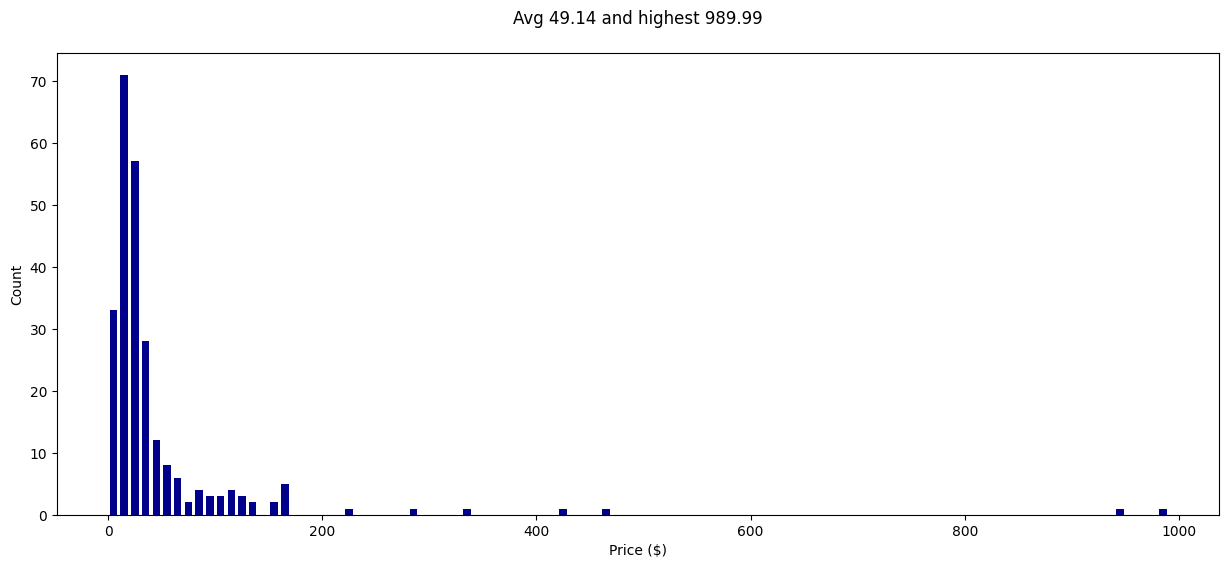

In [ ]:


prices = [float(item.price) for item in test[:250]]
plt.figure(figsize=(15, 6))
plt.title(f"Avg {sum(prices)/len(prices):.2f} and highest {max(prices):,.2f}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="darkblue", bins=range(0, 1000, 10))
plt.show()


In [ ]:

train_prompts = [item.prompt for item in train]
train_prices = [item.price for item in train]
test_prompts = [item.test_prompt() for item in test]
test_prices = [item.price for item in test]


In [ ]:


train_dataset = Dataset.from_dict({"text": train_prompts, "price": train_prices})
test_dataset = Dataset.from_dict({"text": test_prompts, "price": test_prices})
dataset = DatasetDict({
    "train": train_dataset,
    "test": test_dataset
})


In [ ]:

DATASET_NAME = "himpat202/lite-data"
dataset.push_to_hub(DATASET_NAME, private=True)


Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/25 [00:00<?, ?ba/s]

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

                              : 100%|##########| 9.84MB / 9.84MB            

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

                              : 100%|##########|  780kB /  780kB            

README.md:   0%|          | 0.00/412 [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/datasets/himpat202/lite-data/commit/7d4cebc1fc09b570eff0a97a6365a90444ebe147', commit_message='Upload dataset', commit_description='', oid='7d4cebc1fc09b570eff0a97a6365a90444ebe147', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/himpat202/lite-data', endpoint='https://huggingface.co', repo_type='dataset', repo_id='himpat202/lite-data'), pr_revision=None, pr_num=None)

In [ ]:


with open('train_lite.pkl', 'wb') as file:
    pickle.dump(train, file)

with open('test_lite.pkl', 'wb') as file:
    pickle.dump(test, file)


In [ ]:

print(train[0].prompt)


How much does this cost to the nearest dollar?

and Replacement Range Cooktop Drip Pans fit GE, Hotpoint - Two 6 Inch and Two 8 Inch Pans (4 pieces)
Contents 2 x (6 inches) and 2 x (8 inches) bowls, 4 drip bowls total Compatibility This replacement kit works with GE, Hotpoint, Moffat, Monogram (GE), Profile (GE), RCA (GE), and Roper models prior to 1996. replaces 65975, replaces and 65974, 770169 Premium quality Drip bowls are made of durable high-quality material. It features a chrome finish, well-tested by the manufacturer. Durable, stick-free, easy to clean, and dishwasher safe. Ensure long-lasting and effective performance Easy to install Shut off electrical power, tilt the coil

Price is $12.00


In [ ]:


GREEN = "\033[92m"
YELLOW = "\033[93m"
RED = "\033[91m"
RESET = "\033[0m"
COLOR_MAP = {"red":RED, "orange": YELLOW, "green": GREEN}


In [ ]:


load_dotenv(override=True)
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
os.environ['ANTHROPIC_API_KEY'] = os.getenv('ANTHROPIC_API_KEY', 'your-key-if-not-using-env')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')


In [ ]:

with open('train_lite.pkl', 'rb') as file:
    train = pickle.load(file)

with open('test_lite.pkl', 'rb') as file:
    test = pickle.load(file)


In [ ]:


print(train[0].prompt)


How much does this cost to the nearest dollar?

and Replacement Range Cooktop Drip Pans fit GE, Hotpoint - Two 6 Inch and Two 8 Inch Pans (4 pieces)
Contents 2 x (6 inches) and 2 x (8 inches) bowls, 4 drip bowls total Compatibility This replacement kit works with GE, Hotpoint, Moffat, Monogram (GE), Profile (GE), RCA (GE), and Roper models prior to 1996. replaces 65975, replaces and 65974, 770169 Premium quality Drip bowls are made of durable high-quality material. It features a chrome finish, well-tested by the manufacturer. Durable, stick-free, easy to clean, and dishwasher safe. Ensure long-lasting and effective performance Easy to install Shut off electrical power, tilt the coil

Price is $12.00


In [ ]:

print(test[0].test_prompt())


How much does this cost to the nearest dollar?

Setpower Insulated Protective Cover for AJ30 Portable Refrigerator Freezer, suitable for AJ30 Only
Insulation & Waterproof well-made insulation could save battery power and improve cooling efficiency by preventing cold air from flowing away. Durable and Foldable with its oxford cloth outer layer, it's durable and protects your portable refrigerator from scratches and dust. Expanded Bag for Accessories two expanded bags on its side, expand space to store the other accessories. Great Ventilation a hollowed design for positions of vents doesn't affect the ventilation. Attention this insulated cover is ONLY suitable for SetPower AJ30 portable refrigerator. FIT TO AJ30 ONLY. Brand Name Setpower, Model Info AJ30 COVER, model number AJ30 COVER, Installation Type Freestanding, Part AJ30 cover, Special Features Portable, Color

Price is $


In [ ]:


print(train[0].price)


11.99


In [ ]:

class Tester:

    def __init__(self, predictor, title=None, data=test, size=250):
        self.predictor = predictor
        self.data = data
        self.title = title or predictor.__name__.replace("_", " ").title()
        self.size = size
        self.guesses = []
        self.truths = []
        self.errors = []
        self.sles = []
        self.colors = []

    def color_for(self, error, truth):
        if error<40 or error/truth < 0.2:
            return "green"
        elif error<80 or error/truth < 0.4:
            return "orange"
        else:
            return "red"

    def run_datapoint(self, i):
        datapoint = self.data[i]
        guess = self.predictor(datapoint)
        truth = datapoint.price
        error = abs(guess - truth)
        log_error = math.log(truth+1) - math.log(guess+1)
        sle = log_error ** 2
        color = self.color_for(error, truth)
        title = datapoint.title if len(datapoint.title) <= 40 else datapoint.title[:40]+"..."
        self.guesses.append(guess)
        self.truths.append(truth)
        self.errors.append(error)
        self.sles.append(sle)
        self.colors.append(color)
        print(f"{COLOR_MAP[color]}{i+1}: Guess: ${guess:,.2f} Truth: ${truth:,.2f} Error: ${error:,.2f} SLE: {sle:,.2f} Item: {title}{RESET}")

    def chart(self, title):
        max_error = max(self.errors)
        plt.figure(figsize=(12, 8))
        max_val = max(max(self.truths), max(self.guesses))
        plt.plot([0, max_val], [0, max_val], color='deepskyblue', lw=2, alpha=0.6)
        plt.scatter(self.truths, self.guesses, s=3, c=self.colors)
        plt.xlabel('Ground Truth')
        plt.ylabel('Model Estimate')
        plt.xlim(0, max_val)
        plt.ylim(0, max_val)
        plt.title(title)
        plt.show()

    def report(self):
        average_error = sum(self.errors) / self.size
        rmsle = math.sqrt(sum(self.sles) / self.size)
        hits = sum(1 for color in self.colors if color=="green")
        title = f"{self.title} Error=${average_error:,.2f} RMSLE={rmsle:,.2f} Hits={hits/self.size*100:.1f}%"
        self.chart(title)

    def run(self):
        self.error = 0
        for i in range(self.size):
            self.run_datapoint(i)
        self.report()

    @classmethod
    def test(cls, function):
        cls(function).run()


In [ ]:

def random_pricer(item):
    return random.randrange(1,1000)


1: Guess: $655.00 Truth: $65.99 Error: $589.01 SLE: 5.21 Item: Setpower Insulated Protective Cover for ...
2: Guess: $115.00 Truth: $9.68 Error: $105.32 SLE: 5.69 Item: TUAIC Refrigerator Door Light Switch 2 F...
3: Guess: $26.00 Truth: $155.98 Error: $129.98 SLE: 3.10 Item: Kegco Secondary Regulator, 3 Product, Ch...
4: Guess: $760.00 Truth: $5.59 Error: $754.41 SLE: 22.55 Item: MHY62044106 Refrigerator Door Spring 2Pc...
5: Guess: $282.00 Truth: $98.40 Error: $183.60 SLE: 1.09 Item: Ice-O-Matic 9131111-01 Float Valve
6: Guess: $251.00 Truth: $54.99 Error: $196.01 SLE: 2.26 Item: Wireless Temperature & Humidity Bluetoot...
7: Guess: $229.00 Truth: $5.71 Error: $223.29 SLE: 12.49 Item: 3Inch Thermometer Hygrometer for Indoor ...
8: Guess: $143.00 Truth: $9.53 Error: $133.47 SLE: 6.84 Item: GE WH1X2754 GE Timer Knob Assembly,white
9: Guess: $755.00 Truth: $11.24 Error: $743.76 SLE: 17.00 Item: newlifeapp 33001003 Dryer Lint Screen Fi...
10: Guess: $105.00 Truth: $12.88 Error: $92.12 SLE

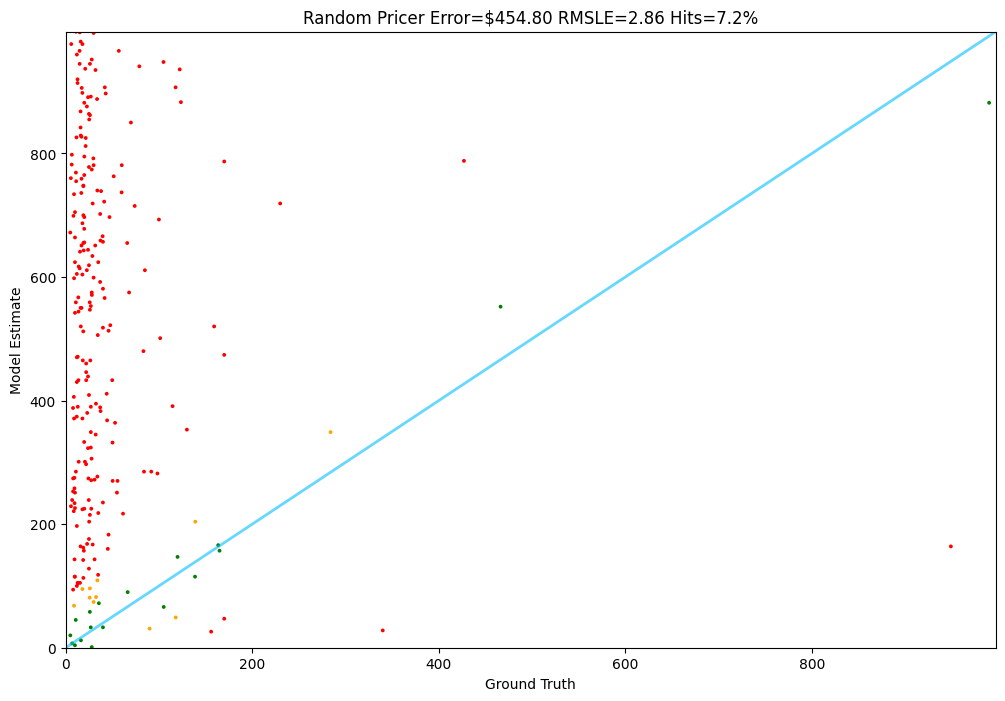

In [ ]:


random.seed(42)

Tester.test(random_pricer)


In [ ]:
# --- from day3.ipynb ---

training_prices = [item.price for item in train]
training_average = sum(training_prices) / len(training_prices)

def constant_pricer(item):
    return training_average


1: Guess: $58.76 Truth: $65.99 Error: $7.23 SLE: 0.01 Item: Setpower Insulated Protective Cover for ...
2: Guess: $58.76 Truth: $9.68 Error: $49.08 SLE: 2.97 Item: TUAIC Refrigerator Door Light Switch 2 F...
3: Guess: $58.76 Truth: $155.98 Error: $97.22 SLE: 0.93 Item: Kegco Secondary Regulator, 3 Product, Ch...
4: Guess: $58.76 Truth: $5.59 Error: $53.17 SLE: 4.86 Item: MHY62044106 Refrigerator Door Spring 2Pc...
5: Guess: $58.76 Truth: $98.40 Error: $39.64 SLE: 0.26 Item: Ice-O-Matic 9131111-01 Float Valve
6: Guess: $58.76 Truth: $54.99 Error: $3.77 SLE: 0.00 Item: Wireless Temperature & Humidity Bluetoot...
7: Guess: $58.76 Truth: $5.71 Error: $53.05 SLE: 4.78 Item: 3Inch Thermometer Hygrometer for Indoor ...
8: Guess: $58.76 Truth: $9.53 Error: $49.23 SLE: 3.01 Item: GE WH1X2754 GE Timer Knob Assembly,white
9: Guess: $58.76 Truth: $11.24 Error: $47.52 SLE: 2.51 Item: newlifeapp 33001003 Dryer Lint Screen Fi...
10: Guess: $58.76 Truth: $12.88 Error: $45.88 SLE: 2.13 Item: Away NV350

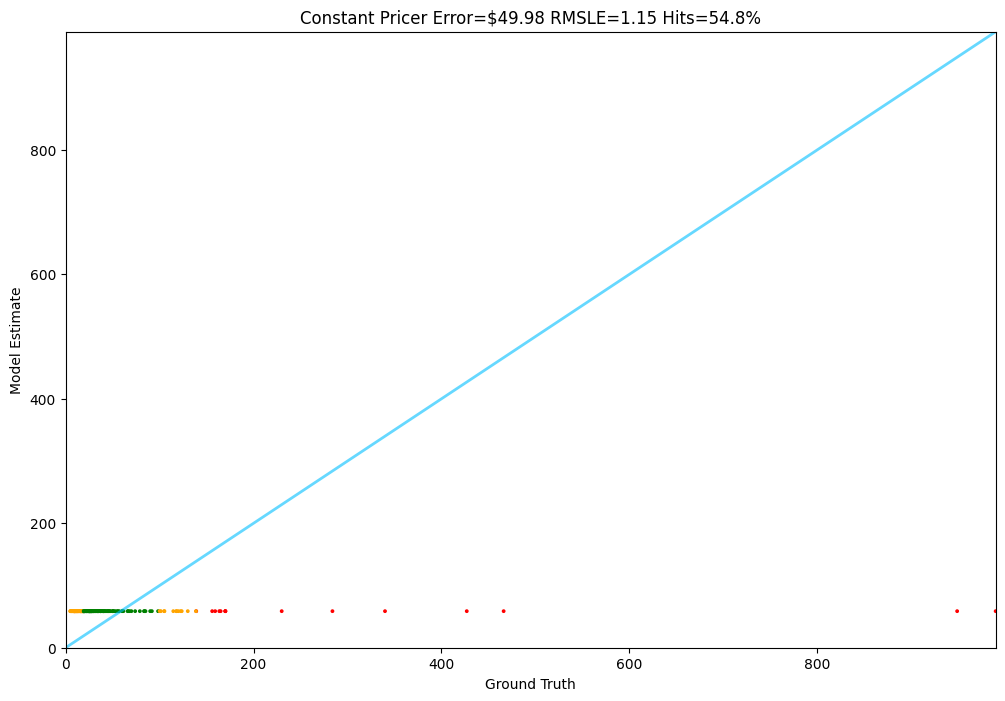

In [ ]:
# --- from day3.ipynb ---
Tester.test(constant_pricer)


In [ ]:

train[0].details


'{"Manufacturer": "Saffire", "Part Number": "WB31T10010 WB31T10011", "Item Weight": "1.17 pounds", "Product Dimensions": "10 x 10 x 2.5 inches", "Country of Origin": "China", "Item model number": "1854&1857", "Included Components": "Drip pans", "Batteries Included?": "No", "Batteries Required?": "No", "Warranty Description": "100% MONEYBACK GUARANTEE: We offer 100% money back guarantee with no questions asked. This great product also comes with 10-year warranty for quality related issues. Purchase with confidence and enjoy our risk-free offer", "Best Sellers Rank": {"Tools & Home Improvement": 162062, "Range Replacement Drip Pans": 144}, "Date First Available": "October 19, 2022"}'

In [ ]:


for item in train:
    item.features = json.loads(item.details)
for item in test:
    item.features = json.loads(item.details)



In [ ]:

train[0].features.keys()


dict_keys(['Manufacturer', 'Part Number', 'Item Weight', 'Product Dimensions', 'Country of Origin', 'Item model number', 'Included Components', 'Batteries Included?', 'Batteries Required?', 'Warranty Description', 'Best Sellers Rank', 'Date First Available'])

In [ ]:


feature_count = Counter()
for item in train:
    for f in item.features.keys():
        feature_count[f]+=1

feature_count.most_common(40)


[('Date First Available', 23322),
 ('Best Sellers Rank', 22032),
 ('Item Weight', 19910),
 ('Item model number', 17497),
 ('Manufacturer', 16933),
 ('Part Number', 16589),
 ('Batteries Required?', 14820),
 ('Brand', 13896),
 ('Product Dimensions', 13718),
 ('Batteries Included?', 12152),
 ('Is Discontinued By Manufacturer', 9299),
 ('Color', 8932),
 ('Material', 8867),
 ('Package Dimensions', 7727),
 ('Brand Name', 6170),
 ('Included Components', 5961),
 ('Item Package Quantity', 5508),
 ('Country of Origin', 5105),
 ('Model Info', 4653),
 ('Special Features', 3284),
 ('Shape', 3157),
 ('Number of Pieces', 3136),
 ('Special Feature', 3131),
 ('Material Type', 2764),
 ('Style', 2686),
 ('Voltage', 2501),
 ('Size', 2405),
 ('Item Dimensions LxWxH', 2346),
 ('Unit Count', 2088),
 ('External Testing Certification', 1959),
 ('Compatible Devices', 1888),
 ('Finish Type', 1874),
 ('Warranty Description', 1778),
 ('Capacity', 1737),
 ('Number of Items', 1405),
 ('Duration', 1329),
 ('Power Sou

In [ ]:


def get_weight(item):
    weight_str = item.features.get('Item Weight')
    if weight_str:
        parts = weight_str.split(' ')
        amount = float(parts[0])
        unit = parts[1].lower()
        if unit=="pounds":
            return amount
        elif unit=="ounces":
            return amount / 16
        elif unit=="grams":
            return amount / 453.592
        elif unit=="milligrams":
            return amount / 453592
        elif unit=="kilograms":
            return amount / 0.453592
        elif unit=="hundredths" and parts[2].lower()=="pounds":
            return amount / 100
        else:
            print(weight_str)
    return None


In [ ]:

weights = [get_weight(t) for t in train]
weights = [w for w in weights if w]


In [ ]:

average_weight = sum(weights)/len(weights)
average_weight


3.9558465173350927

In [ ]:

def get_weight_with_default(item):
    weight = get_weight(item)
    return weight or average_weight


In [ ]:

def get_rank(item):
    rank_dict = item.features.get("Best Sellers Rank")
    if rank_dict:
        ranks = rank_dict.values()
        return sum(ranks)/len(ranks)
    return None


In [ ]:

ranks = [get_rank(t) for t in train]
ranks = [r for r in ranks if r]
average_rank = sum(ranks)/len(ranks)
average_rank


238325.041401756

In [ ]:

def get_rank_with_default(item):
    rank = get_rank(item)
    return rank or average_rank


In [ ]:

def get_text_length(item):
    return len(item.test_prompt())


In [ ]:


brands = Counter()
for t in train:
    brand = t.features.get("Brand")
    if brand:
        brands[brand]+=1


brands.most_common(40)


[('Upstart Battery', 483),
 ('GE', 480),
 ('Whirlpool', 466),
 ('Frigidaire', 406),
 ('Supplying Demand', 277),
 ('UpStart Components', 198),
 ('SAMSUNG', 182),
 ('BlueStars', 158),
 ('Supco', 134),
 ('ICEPURE', 133),
 ('LG', 121),
 ('Broan-NuTone', 98),
 ('Lifetime Appliance Parts', 89),
 ('AMI PARTS', 88),
 ('PartsBroz', 82),
 ('Waterdrop', 77),
 ('Swift Green Filters', 71),
 ('Beaquicy', 71),
 ('Air Filter Factory', 67),
 ('Nostalgic Warehouse', 66),
 ('Generic', 65),
 ('Electrolux', 62),
 ('PUREPLUS', 58),
 ('Melitta', 57),
 ('HQRP', 56),
 ('Wowfeel', 55),
 ('Empava', 55),
 ('Aqua Fresh', 53),
 ('Edgewater Parts', 49),
 ('Tier1', 48),
 ('AQUA CREST', 48),
 ('COSTWAY', 47),
 ('Refresh', 47),
 ('Denali Pure', 46),
 ('BUNN', 46),
 ('BRBHOM', 44),
 ('GOLDEN ICEPURE', 44),
 ('EXCELPURE', 43),
 ('Seentech', 42),
 ('Range Kleen', 41)]

In [ ]:

TOP_ELECTRONICS_BRANDS = ["hp", "dell", "lenovo", "samsung", "asus", "sony", "canon", "apple", "intel"]
def is_top_electronics_brand(item):
    brand = item.features.get("Brand")
    return brand and brand.lower() in TOP_ELECTRONICS_BRANDS


In [ ]:

def get_features(item):
    return {
        "weight": get_weight_with_default(item),
        "rank": get_rank_with_default(item),
        "text_length": get_text_length(item),
        "is_top_electronics_brand": 1 if is_top_electronics_brand(item) else 0
    }


In [ ]:

get_features(train[1])


{'weight': 55.0,
 'rank': 1356.5,
 'text_length': 771,
 'is_top_electronics_brand': 0}

In [ ]:


def list_to_dataframe(items):
    features = [get_features(item) for item in items]
    df = pd.DataFrame(features)
    df['price'] = [item.price for item in items]
    return df

train_df = list_to_dataframe(train)
test_df = list_to_dataframe(test[:250])


In [ ]:


np.random.seed(42)

feature_columns = ['weight', 'rank', 'text_length', 'is_top_electronics_brand']

X_train = train_df[feature_columns]
y_train = train_df['price']
X_test = test_df[feature_columns]
y_test = test_df['price']

model = LinearRegression()
model.fit(X_train, y_train)

for feature, coef in zip(feature_columns, model.coef_):
    print(f"{feature}: {coef}")
print(f"Intercept: {model.intercept_}")

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")


weight: 4.9935660840682035
rank: -1.4753193495317861e-05
text_length: 0.034373937543311646
is_top_electronics_brand: 5.965762485264739
Intercept: 15.561992621832822
Mean Squared Error: 3988.5353049671835
R-squared Score: 0.605348339648045


In [ ]:


def linear_regression_pricer(item):
    features = get_features(item)
    features_df = pd.DataFrame([features])
    return model.predict(features_df)[0]


1: Guess: $65.85 Truth: $65.99 Error: $0.14 SLE: 0.00 Item: Setpower Insulated Protective Cover for ...
2: Guess: $54.80 Truth: $9.68 Error: $45.12 SLE: 2.73 Item: TUAIC Refrigerator Door Light Switch 2 F...
3: Guess: $59.64 Truth: $155.98 Error: $96.34 SLE: 0.90 Item: Kegco Secondary Regulator, 3 Product, Ch...
4: Guess: $41.33 Truth: $5.59 Error: $35.74 SLE: 3.46 Item: MHY62044106 Refrigerator Door Spring 2Pc...
5: Guess: $43.62 Truth: $98.40 Error: $54.78 SLE: 0.64 Item: Ice-O-Matic 9131111-01 Float Valve
6: Guess: $43.55 Truth: $54.99 Error: $11.44 SLE: 0.05 Item: Wireless Temperature & Humidity Bluetoot...
7: Guess: $60.98 Truth: $5.71 Error: $55.27 SLE: 4.94 Item: 3Inch Thermometer Hygrometer for Indoor ...
8: Guess: $40.62 Truth: $9.53 Error: $31.09 SLE: 1.89 Item: GE WH1X2754 GE Timer Knob Assembly,white
9: Guess: $36.66 Truth: $11.24 Error: $25.42 SLE: 1.26 Item: newlifeapp 33001003 Dryer Lint Screen Fi...
10: Guess: $36.32 Truth: $12.88 Error: $23.44 SLE: 0.98 Item: Away NV35

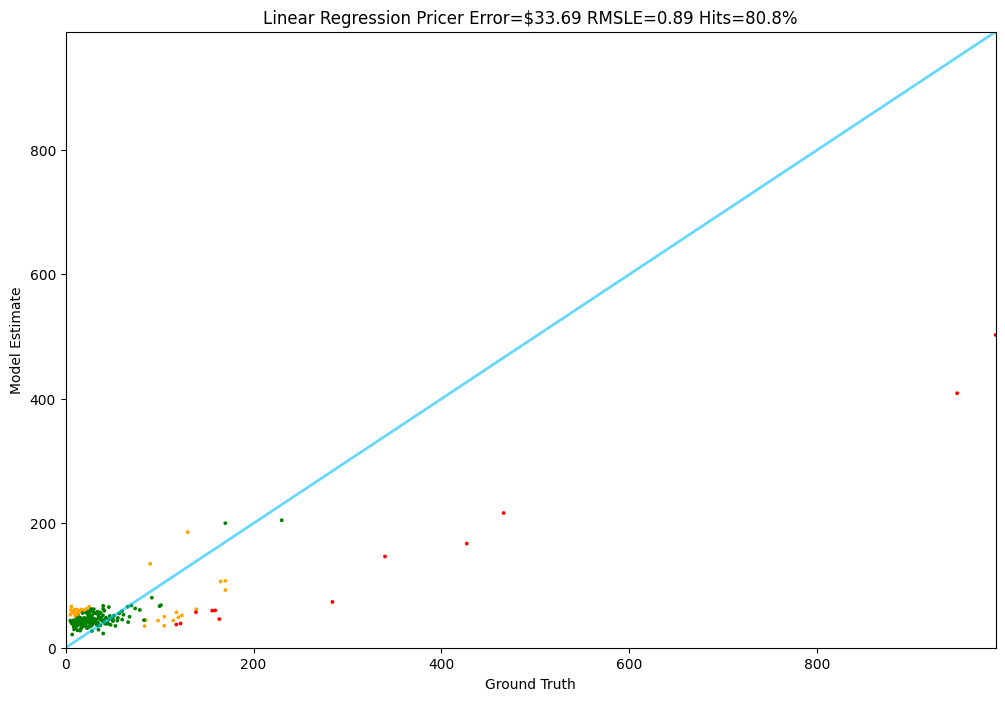

In [ ]:


Tester.test(linear_regression_pricer)


In [ ]:


prices = np.array([float(item.price) for item in train])
documents = [item.test_prompt() for item in train]


In [ ]:


np.random.seed(42)
vectorizer = CountVectorizer(max_features=1000, stop_words='english')
X = vectorizer.fit_transform(documents)
regressor = LinearRegression()
regressor.fit(X, prices)


LinearRegression()

In [ ]:

def bow_lr_pricer(item):
    x = vectorizer.transform([item.test_prompt()])
    return max(regressor.predict(x)[0], 0)


1: Guess: $26.13 Truth: $65.99 Error: $39.86 SLE: 0.82 Item: Setpower Insulated Protective Cover for ...
2: Guess: $36.82 Truth: $9.68 Error: $27.14 SLE: 1.60 Item: TUAIC Refrigerator Door Light Switch 2 F...
3: Guess: $77.53 Truth: $155.98 Error: $78.45 SLE: 0.48 Item: Kegco Secondary Regulator, 3 Product, Ch...
4: Guess: $29.89 Truth: $5.59 Error: $24.30 SLE: 2.39 Item: MHY62044106 Refrigerator Door Spring 2Pc...
5: Guess: $156.96 Truth: $98.40 Error: $58.56 SLE: 0.21 Item: Ice-O-Matic 9131111-01 Float Valve
6: Guess: $0.00 Truth: $54.99 Error: $54.99 SLE: 16.20 Item: Wireless Temperature & Humidity Bluetoot...
7: Guess: $0.00 Truth: $5.71 Error: $5.71 SLE: 3.62 Item: 3Inch Thermometer Hygrometer for Indoor ...
8: Guess: $31.10 Truth: $9.53 Error: $21.57 SLE: 1.24 Item: GE WH1X2754 GE Timer Knob Assembly,white
9: Guess: $33.26 Truth: $11.24 Error: $22.02 SLE: 1.06 Item: newlifeapp 33001003 Dryer Lint Screen Fi...
10: Guess: $108.19 Truth: $12.88 Error: $95.31 SLE: 4.25 Item: Away NV3

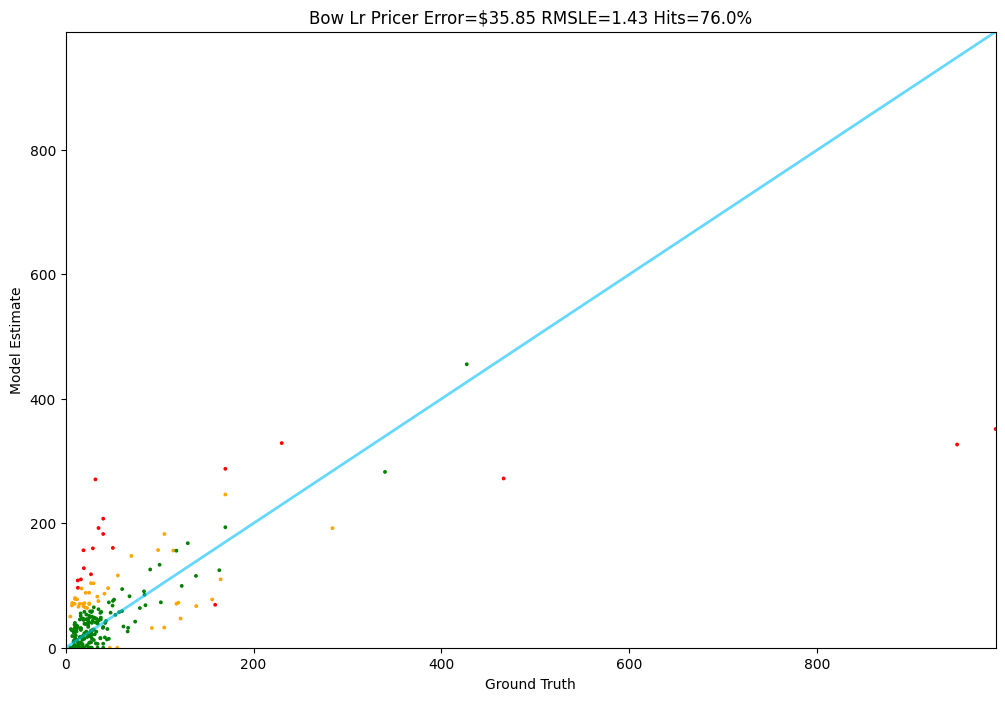

In [ ]:


Tester.test(bow_lr_pricer)


In [ ]:


np.random.seed(42)

processed_docs = [simple_preprocess(doc) for doc in documents]

w2v_model = Word2Vec(sentences=processed_docs, vector_size=400, window=5, min_count=1, workers=8)


In [ ]:


def document_vector(doc):
    doc_words = simple_preprocess(doc)
    word_vectors = [w2v_model.wv[word] for word in doc_words if word in w2v_model.wv]
    return np.mean(word_vectors, axis=0) if word_vectors else np.zeros(w2v_model.vector_size)

X_w2v = np.array([document_vector(doc) for doc in documents])


In [ ]:


word2vec_lr_regressor = LinearRegression()
word2vec_lr_regressor.fit(X_w2v, prices)


LinearRegression()

In [ ]:

def word2vec_lr_pricer(item):
    doc = item.test_prompt()
    doc_vector = document_vector(doc)
    return max(0, word2vec_lr_regressor.predict([doc_vector])[0])


1: Guess: $60.27 Truth: $65.99 Error: $5.72 SLE: 0.01 Item: Setpower Insulated Protective Cover for ...
2: Guess: $33.77 Truth: $9.68 Error: $24.09 SLE: 1.39 Item: TUAIC Refrigerator Door Light Switch 2 F...
3: Guess: $158.68 Truth: $155.98 Error: $2.70 SLE: 0.00 Item: Kegco Secondary Regulator, 3 Product, Ch...
4: Guess: $98.03 Truth: $5.59 Error: $92.44 SLE: 7.34 Item: MHY62044106 Refrigerator Door Spring 2Pc...
5: Guess: $98.58 Truth: $98.40 Error: $0.18 SLE: 0.00 Item: Ice-O-Matic 9131111-01 Float Valve
6: Guess: $57.33 Truth: $54.99 Error: $2.34 SLE: 0.00 Item: Wireless Temperature & Humidity Bluetoot...
7: Guess: $50.52 Truth: $5.71 Error: $44.81 SLE: 4.15 Item: 3Inch Thermometer Hygrometer for Indoor ...
8: Guess: $0.00 Truth: $9.53 Error: $9.53 SLE: 5.54 Item: GE WH1X2754 GE Timer Knob Assembly,white
9: Guess: $41.93 Truth: $11.24 Error: $30.69 SLE: 1.57 Item: newlifeapp 33001003 Dryer Lint Screen Fi...
10: Guess: $110.81 Truth: $12.88 Error: $97.93 SLE: 4.35 Item: Away NV350 N

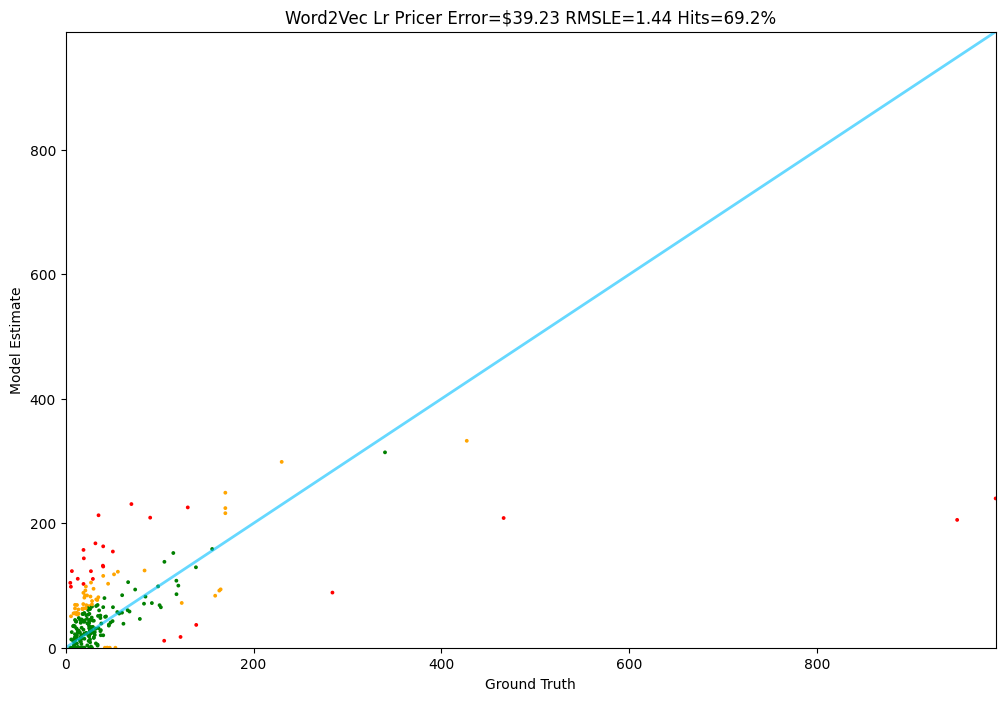

In [ ]:

Tester.test(word2vec_lr_pricer)


In [ ]:

np.random.seed(42)
svr_regressor = LinearSVR()

svr_regressor.fit(X_w2v, prices)


LinearSVR()

In [ ]:

def svr_pricer(item):
    np.random.seed(42)
    doc = item.test_prompt()
    doc_vector = document_vector(doc)
    return max(float(svr_regressor.predict([doc_vector])[0]),0)


1: Guess: $38.05 Truth: $65.99 Error: $27.94 SLE: 0.29 Item: Setpower Insulated Protective Cover for ...
2: Guess: $32.19 Truth: $9.68 Error: $22.51 SLE: 1.29 Item: TUAIC Refrigerator Door Light Switch 2 F...
3: Guess: $44.22 Truth: $155.98 Error: $111.76 SLE: 1.55 Item: Kegco Secondary Regulator, 3 Product, Ch...
4: Guess: $23.99 Truth: $5.59 Error: $18.40 SLE: 1.78 Item: MHY62044106 Refrigerator Door Spring 2Pc...
5: Guess: $104.39 Truth: $98.40 Error: $5.99 SLE: 0.00 Item: Ice-O-Matic 9131111-01 Float Valve
6: Guess: $28.33 Truth: $54.99 Error: $26.66 SLE: 0.42 Item: Wireless Temperature & Humidity Bluetoot...
7: Guess: $27.74 Truth: $5.71 Error: $22.03 SLE: 2.12 Item: 3Inch Thermometer Hygrometer for Indoor ...
8: Guess: $29.43 Truth: $9.53 Error: $19.90 SLE: 1.13 Item: GE WH1X2754 GE Timer Knob Assembly,white
9: Guess: $28.80 Truth: $11.24 Error: $17.56 SLE: 0.79 Item: newlifeapp 33001003 Dryer Lint Screen Fi...
10: Guess: $31.84 Truth: $12.88 Error: $18.96 SLE: 0.74 Item: Away NV

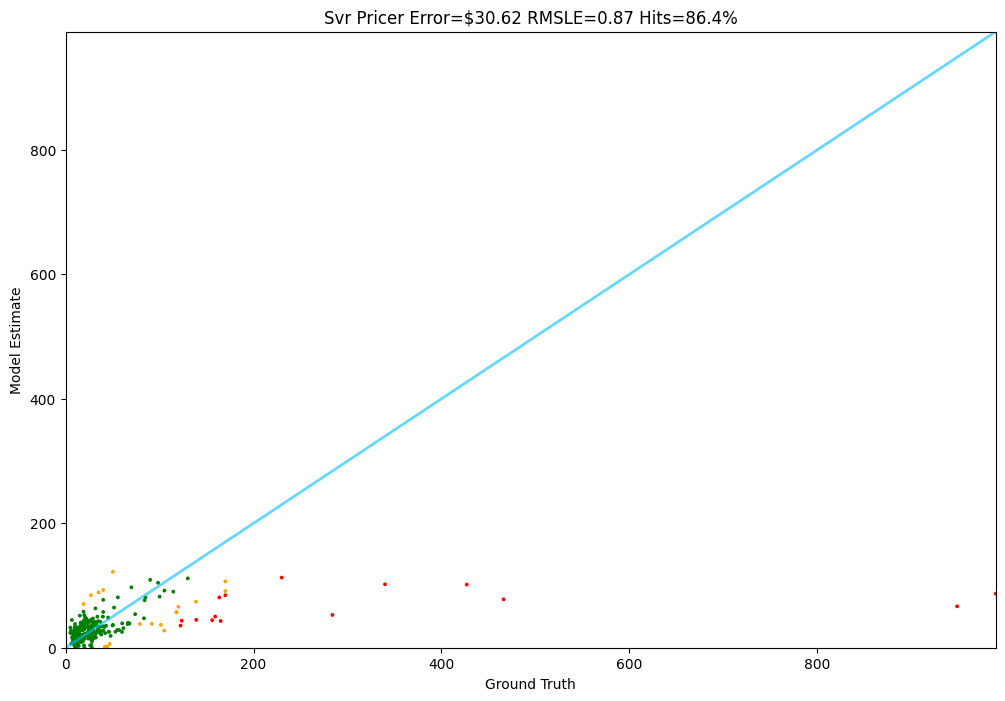

In [ ]:

Tester.test(svr_pricer)


In [ ]:

openai = OpenAI()
claude = Anthropic()


In [ ]:


with open('train_lite.pkl', 'rb') as file:
    train = pickle.load(file)

with open('test_lite.pkl', 'rb') as file:
    test = pickle.load(file)


In [ ]:
# Write the test set to a CSV

import csv
with open('human_input.csv', 'w') as csvfile:
    writer = csv.writer(csvfile)
    for t in test[:250]:
        writer.writerow([t.test_prompt(), 0])

In [ ]:
# Read it back in

human_predictions = []
with open('human_output.csv', 'r') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        human_predictions.append(float(row[1]))

In [ ]:
def human_pricer(item):
    idx = test.index(item)
    return human_predictions[idx]

In [ ]:
from testing import Tester

1: Guess: $120.00 Truth: $65.99 Error: $54.01 SLE: 0.35 Item: Setpower Insulated Protective Cover for ...
2: Guess: $80.00 Truth: $9.68 Error: $70.32 SLE: 4.10 Item: TUAIC Refrigerator Door Light Switch 2 F...
3: Guess: $35.00 Truth: $155.98 Error: $120.98 SLE: 2.17 Item: Kegco Secondary Regulator, 3 Product, Ch...
4: Guess: $350.00 Truth: $5.59 Error: $344.41 SLE: 15.80 Item: MHY62044106 Refrigerator Door Spring 2Pc...
5: Guess: $75.00 Truth: $98.40 Error: $23.40 SLE: 0.07 Item: Ice-O-Matic 9131111-01 Float Valve
6: Guess: $12.00 Truth: $54.99 Error: $42.99 SLE: 2.13 Item: Wireless Temperature & Humidity Bluetoot...
7: Guess: $115.00 Truth: $5.71 Error: $109.29 SLE: 8.12 Item: 3Inch Thermometer Hygrometer for Indoor ...
8: Guess: $100.00 Truth: $9.53 Error: $90.47 SLE: 5.11 Item: GE WH1X2754 GE Timer Knob Assembly,white
9: Guess: $300.00 Truth: $11.24 Error: $288.76 SLE: 10.26 Item: newlifeapp 33001003 Dryer Lint Screen Fi...
10: Guess: $80.00 Truth: $12.88 Error: $67.12 SLE: 3.11 Ite

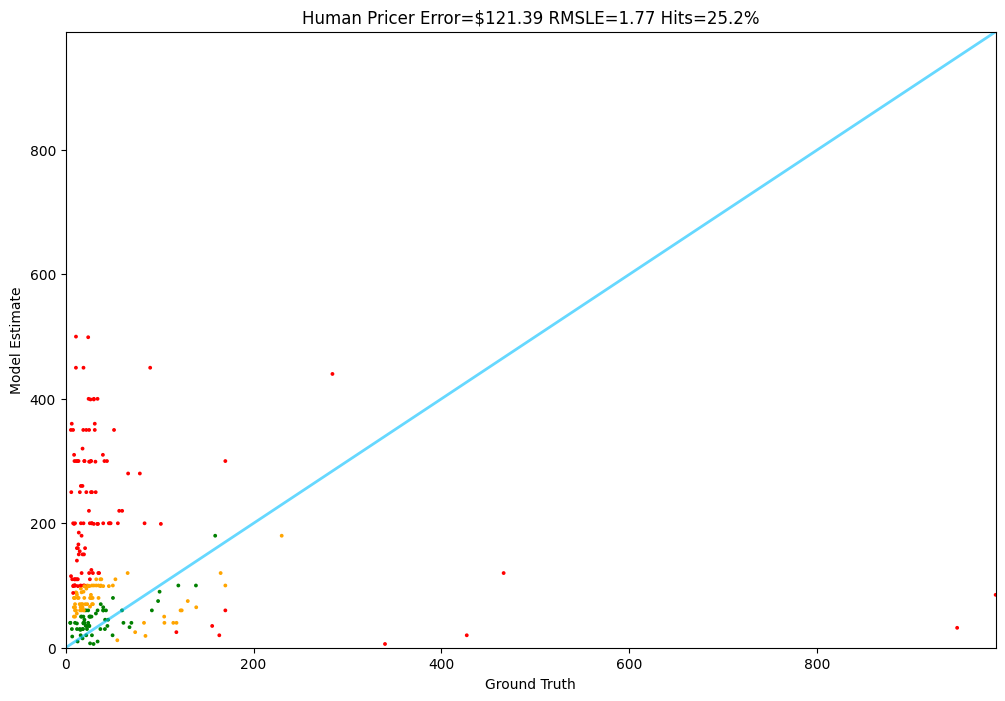

In [ ]:
Tester.test(human_pricer, test)

In [ ]:
# --- from day4-results.ipynb ---

def messages_for(item):
    system_message = "You estimate prices of items. Reply only with the price, no explanation"
    user_prompt = item.test_prompt().replace(" to the nearest dollar","").replace("\n\nPrice is $","")
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": "Price is $"}
    ]


In [ ]:
# --- from day4-results.ipynb ---

messages_for(test[0])


[{'role': 'system',
  'content': 'You estimate prices of items. Reply only with the price, no explanation'},
 {'role': 'user',
  'content': "How much does this cost?\n\nSetpower Insulated Protective Cover for AJ30 Portable Refrigerator Freezer, suitable for AJ30 Only\nInsulation & Waterproof well-made insulation could save battery power and improve cooling efficiency by preventing cold air from flowing away. Durable and Foldable with its oxford cloth outer layer, it's durable and protects your portable refrigerator from scratches and dust. Expanded Bag for Accessories two expanded bags on its side, expand space to store the other accessories. Great Ventilation a hollowed design for positions of vents doesn't affect the ventilation. Attention this insulated cover is ONLY suitable for SetPower AJ30 portable refrigerator. FIT TO AJ30 ONLY. Brand Name Setpower, Model Info AJ30 COVER, model number AJ30 COVER, Installation Type Freestanding, Part AJ30 cover, Special Features Portable, Color"

In [ ]:


def get_price(s):
    s = s.replace('$','').replace(',','')
    match = re.search(r"[-+]?\d*\.\d+|\d+", s)
    return float(match.group()) if match else 0


In [ ]:

get_price("The price is roughly $99.99 because blah blah")


99.99

In [ ]:


def gpt_4o_mini(item):
    response = openai.chat.completions.create(
        model="gpt-4o-mini",
        messages=messages_for(item),
        seed=42,
        max_tokens=5
    )
    reply = response.choices[0].message.content
    return get_price(reply)


In [ ]:

test[0].price


65.99

In [ ]:

Tester.test(gpt_4o_mini, test)


In [ ]:


def gpt_4o_frontier(item):
    response = openai.chat.completions.create(
        model="gpt-4o-2024-08-06",
        messages=messages_for(item),
        seed=42,
        max_tokens=5
    )
    reply = response.choices[0].message.content
    return get_price(reply)


In [ ]:
Tester.test(gpt_4o_frontier, test)

## Notes
- If any import or path errors occur, ensure the separate helper files are uploaded and sys.path is set correctly.
- This merge removed comment-only lines to keep cells compact; adjust if you want more explanation.
